## Importing the Libraries

In [134]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [135]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [136]:
df.head() # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [137]:
df.shape

(24699, 2)

## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

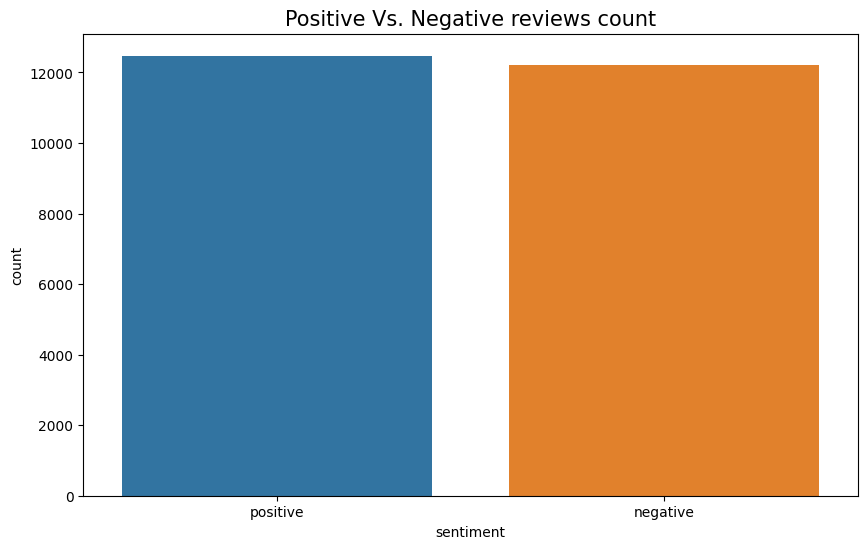

In [138]:
plt.figure(figsize = (10,6))
sns.countplot(x='sentiment', data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


In [139]:
df['sentiment'].value_counts()

positive    12474
negative    12225
Name: sentiment, dtype: int64

## Upsampling the minority class

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [140]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=='positive']
df_minority = df[df['sentiment']=='negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)
df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [141]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
# df_upsampled['sentiment'].value_counts()
df_upsampled[df_upsampled['sentiment']=='negative'].shape
# df_upsampled_neg.shape

(12474, 2)

In [142]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment']=='positive'].shape

(12474, 2)

In [143]:
df_upsampled.shape

(24948, 2)

In [144]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]
## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [145]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

In [146]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

## Pre-process the reviews: 

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [147]:
# TASK CELL
import re
import string

def remove_stopwords(text):
    temp=[]
    for word in text.split():
        if word in stopwords.words('english'):
            temp.append('')
        else:
            temp.append(word)
    x=temp[:]
    temp.clear()
    return " ".join(x)

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review_cleaned=review.lower() #converting the reviews to lowercase
    review_cleaned=re.sub(r'<.*?>','',review_cleaned)  #the html tags are replaced with the empty strings
    review_cleaned=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', review_cleaned) #removing URL's form the text
    #removing punctuations form the text
    exclude=string.punctuation
    review_cleaned=review_cleaned.translate(str.maketrans('','',exclude))
    review_cleaned=remove_stopwords(review_cleaned) #calling an external function that removes the stopwords from each review.
    ps=PorterStemmer() #initializing the porter stemmer object
    review_cleaned=" ".join([ps.stem(word) for word in review_cleaned.split()])
    return review_cleaned

## Implement a find_occurrence function

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [148]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n=0

    if (word,label) in frequency:
        n=frequency[word,label]  
    return n

# frequency={('he','positive'):2}
# print(find_occurrence(frequency, 'he', 'positive'))
# t="he was running and eating he at same time. He has bad habit of swimming after playing long hours in the Sun"
# word_tokens=t.split()
# word_count = {}
# for word in word_tokens:
#     if word in word_count:
#         word_count[word] += 1
#     else:
#         word_count[word] = 1

# for word, count in word_count.items():
#     print(f"'{word}': {count}")
# print(word_count)

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [149]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [150]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [151]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

"In my work with the only nationwide non-profit organization, Security On Campus, Inc. dedicated exclusively to the issue of college campus crime prevention and student awareness I see all too often the type of campus violence and `cover-up' through secret campus courts portrayed in the movie `Silencing Mary.' In fact we receive numerous calls and requests for information every month from campus reporters such as `Mary' who are facing similar situations.<br /><br />Its depiction of a campus rape and the subsequent crusade by `Mary,' the victim's roommate and a student journalist played exceedingly well by Melissa Joan Hart, for justice was very well done and accurately researched.<br /><br />This was the first television movie that I have ever seen that I felt truly reflected and encompassed all of the various complex issues associated with how rape and other violent crimes are dealt with on our nation's college and university campuses. Although it would not be possible to address all 

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [152]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

work nationwid nonprofit organ secur campu inc dedic exclus issu colleg campu crime prevent student awar see often type campu violenc coverup secret campu court portray movi silenc mari fact receiv numer call request inform everi month campu report mari face similar situationsit depict campu rape subsequ crusad mari victim roommat student journalist play exceedingli well melissa joan hart justic well done accur researchedthi first televis movi ever seen felt truli reflect encompass variou complex issu associ rape violent crime dealt nation colleg univers campus although would possibl address issu depth 2 hour movi come closer other ive seen


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Implementing review counter function:

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [153]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
       
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        # Your code here
        if (word,label) in output_occurrence:
            output_occurrence[word,label]+=1
        else:
           output_occurrence[word,label]=1
  
    return output_occurrence

### Testing the above function with example reviews:


In [154]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

In [155]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [156]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('work', 0): 2871,
 ('nationwid', 0): 4,
 ('nonprofit', 0): 1,
 ('organ', 0): 79,
 ('secur', 0): 72,
 ('campu', 0): 22,
 ('inc', 0): 13,
 ('dedic', 0): 82,
 ('exclus', 0): 30,
 ('issu', 0): 373,
 ('colleg', 0): 167,
 ('crime', 0): 383,
 ('prevent', 0): 80,
 ('student', 0): 274,
 ('awar', 0): 138,
 ('see', 0): 5773,
 ('often', 0): 744,
 ('type', 0): 540,
 ('violenc', 0): 413,
 ('coverup', 0): 8,
 ('secret', 0): 307,
 ('court', 0): 61,
 ('portray', 0): 955,
 ('movi', 0): 17226,
 ('silenc', 0): 82,
 ('mari', 0): 261,
 ('fact', 0): 1310,
 ('receiv', 0): 246,
 ('numer', 0): 119,
 ('call', 0): 897,
 ('request', 0): 36,
 ('inform', 0): 272,
 ('everi', 0): 1572,
 ('month', 0): 170,
 ('report', 0): 168,
 ('face', 0): 826,
 ('similar', 0): 454,
 ('situationsit', 0): 1,
 ('depict', 0): 345,
 ('rape', 0): 149,
 ('subsequ', 0): 85,
 ('crusad', 0): 19,
 ('victim', 0): 241,
 ('roommat', 0): 41,
 ('journalist', 0): 50,
 ('play', 0): 3957,
 ('exceedingli', 0): 9,
 ('well', 0): 4615,
 ('melissa', 0): 2

## Training the Naive Bayes Model: 

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [157]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set()
    for pair in freqs.keys():
        vocab.add(pair[0])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]==0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos =num_pos+freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg = num_neg+freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = y_train.shape
    # num_doc = len(y_train)


    # Calculate D_pos, the number of positive documents
    pos_num_docs = sum(1 for x in train_y if x==1)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(1 for x in train_y if x < 1)
    # neg_num_docs = num_doc - pos_num_docs

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs) 

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [158]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
88085


## Implementing Naive Bayes Predict Function:

It is now time to make our prediction as to whether a given review is negative or positive respectively. 



In [159]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''  
      # process the review to get a list of words
    word_l = clean_review(review)
    word_l=word_l.split()
    # initialize probability to zero
    total_prob = 0
    # add the logprior
    total_prob += logprior
    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
    
    if total_prob <0:
        total_prob=1
    else:
        total_prob=0
        
    return total_prob

In [160]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


## Implementing Naive Bayes Test function

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [161]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood):
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))

    accuracy = 1-error


    return accuracy

In [162]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


In [166]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)
# # print(logprior)
# print(len(loglikelihood))
# loglikelihood['hate']

1

# Evaluate the accuracy
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [111]:
import random
random.seed(42)
## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]
## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])
output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [112]:
#model parameters
freqs = review_counter({}, X_train, y_train)
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
88543


In [113]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

training_predictions = [naive_bayes_predict(x, logprior, loglikelihood) for x in X_train]
confusion_matrix_training = confusion_matrix(y_train, training_predictions)
print("Training TP :", confusion_matrix_training[1][1])
print("Training TN :", confusion_matrix_training[0][0])
print("Training FP :", confusion_matrix_training[0][1])
print("Training FN :", confusion_matrix_training[1][0])

Training TP : 9595
Training TN : 9086
Training FP : 914
Training FN : 405


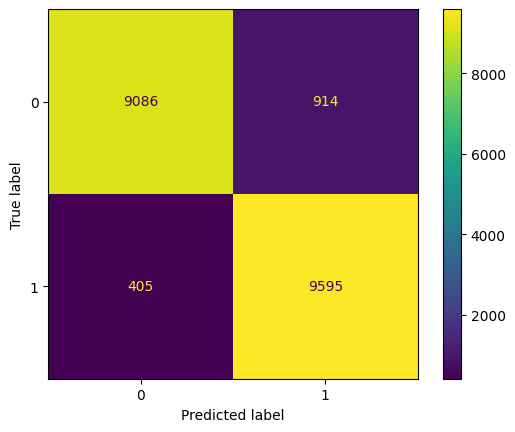

In [114]:
import matplotlib.pyplot as plt
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training)
# Plot the confusion matrix using the plot method
disp.plot()
# Display the plot
plt.show()

In [115]:
testing_predictions = [naive_bayes_predict(x, logprior, loglikelihood) for x in X_test]
confusion_matrix__testing = confusion_matrix(y_test, testing_predictions)
print("Testing TP :", confusion_matrix__testing[1][1])
print("Testing TN :", confusion_matrix__testing[0][0])
print("Testing FP :", confusion_matrix__testing[0][1])
print("Testing FN :", confusion_matrix__testing[1][0])
confusion_matrix__testing

Testing TP : 2258
Testing TN : 2098
Testing FP : 376
Testing FN : 216


array([[2098,  376],
       [ 216, 2258]], dtype=int64)

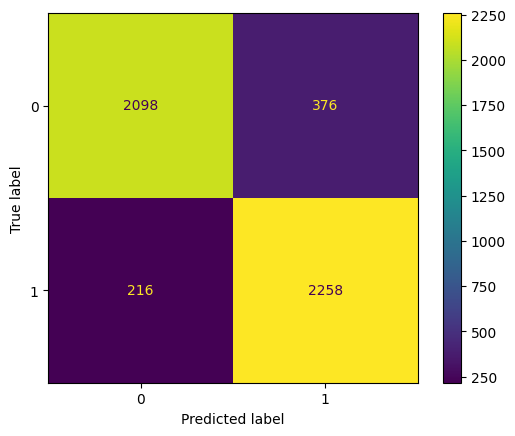

In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix__testing)
# Plot the confusion matrix using the plot method
disp.plot()
# Display the plot
plt.show()

In [189]:
#to check false negatives
false_negatives = [i for i, (true, pred) in enumerate(zip(y_test, testing_predictions)) if true == 0 and pred == 1]
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
for i,fp in enumerate(false_negatives):
    # print(f"Index: {fp}")
    print(f"Test Sample: {x_test[fp]}")
    print(f"Actual Target Value: {y_test[fp]}")
    print(f"Predicted Value: {testing_predictions[fp]}")
    print("------------------------")
    # if i>=2:
    #     break

Test Sample: The selection of Sylvester Stallone to perform the protagonist by Renny Harlin is commendable since Stallone is that sort of tough and craggy person who had earlier rendered the requisite audaciously versatile aura to the characters of Rocky Balbao and Rambo. But to compare Die Hard series with Cliffhanger is a far-fetched notion.<br /><br />The excellently crafted opening scene introduces the audience to the thrill, suspense and intrigue which is going to engulf them in the ensuing bloody and perilous encounter with the outlaws. The heist and the high altitude transfer of hard cash in suit cases from one plane to the other is something not filmed before.<br /><br />The biting cold of the snow capped Alps and the unfolding deceit and treachery among the antagonist forces makes one shiver with trepidation. The forces of awesome adventure and ruthless murder kicks the drama through to the end.<br /><br />Good movies are not made every year and people don't get a feast for ey

**Review:**  It's a mistake to refer to any film of this era as a horror film. Most early German films with supernatural themes are not so much horror films as they are dark fantasies borrowed from the works of early German Romantics like E. T. A. Hoffman and others. In Fritz Lang's "Der Mude Tod" (also from 1921) Death personified takes a young man away from his sweetheart, but in Lang's film the characters' destiny cannot be mitigated by behavior. Neither of the young lovers deserves to die, but they are destined by circumstances to be reunited only in death.In Victor Seastrom's "Korkarlen," however, repentance is always an option. Destiny can be altered - and death deferred - through the characters' choices. Although scenes of the Phantom Carriage collecting souls are genuinely eerie, these horrific images of Death as the great leveler are compromised by Death's offer of redemption to the real monster of this tale, David Holm, a brutal drunk who, because of a perverse hatred of humanity, spreads tuberculosis and emotional misery to everyone he comes in contact with.One New Year's Eve Holm is struck down in a fight with a drinking companion. As the first person to die on the stroke of midnight Holm must become the driver of the Phantom Carriage and collect souls during the new year. The Phantom Carriage, driven by an old acquaintance who had started Holm on his road to ruin, comes for his soul and takes him on a journey of self discovery. Along the way Holm sees the horror he has inflicted on his family and the people who tried to help him.Perhaps my disappointment with the film's ending is a criticism of the Selma LagerlÃ¶f novel on which the film is based. But I would have preferred to see David Holm unable to escape his destiny, and to see his repentance come too late to prevent his wife from poisoning his two children and herself, and to see Holm suffer for the consequences of his sins by being made to collect their souls. It would have been a fitting punishment and a horror more immense than witnessing the abuse he inflicted on others. In the film, however, the unalterable nature of destiny isn't the message; redemption is. The driver of the carriage allows Holm's spirit to return to his body, and he rescues his family in the nick of time. His repentance smacks of Scrooge's repentance in "A Christmas Carol." If the trite and sentimental ending does not offend you, there is still much to admire in the film's images. The special effects are astonishing when measured by the standards of the day, and still hold up, which is more miraculous when you consider that these double exposures were created inside a hand-cranked camera. Also, the restored film on Tartan's new DVD looks fabulous.<br>
Actual Target Value: 0<br>
Predicted Value: 1<br><br>
**Reason:** In the review, there are several negative phrases such as "disappointment", "brutal drunk", "pervasive hatred", "horror", and "trite and sentimental ending". These phrases could have contributed to the model predicting the review as negative.

However, the actual sentiment of the review is positive. This discrepancy could be due to a few factors:
Phrases like "astonishing" and "fabulous" are positive in this context, but the model might not capture this.
The review contains complex sentiment where it criticizes certain aspects of the film but also praises others. This can be challenging for a model to accurately classify.
The model might not handle negations well. For example, in the phrase "not so much horror films as they are dark fantasies", the word "not" changes the sentiment of the sentence, but if the model doesn't account for this, it can lead to errors.

In [190]:
#to check false positives
false_positives = [i for i, (true, pred) in enumerate(zip(y_test, testing_predictions)) if true == 1 and pred == 0]
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
for i,fp in enumerate(false_positives):
    # print(f"Index: {fp}")
    print(f"Test Sample: {x_test[fp]}")
    print(f"Actual Target Value: {y_test[fp]}")
    print(f"Predicted Value: {testing_predictions[fp]}")
    print("------------------------")
    # if i>=2:
    #     break


Test Sample: A lot of people don't think Dan Aykroyd is funny. This movie proves otherwise. Aykroyd is brilliant delivering his one-liners in this comedy. The only major problem with this is that it wastes far too much time near the end jumping back and forth from Aykroyd's character and the doctor who is pursuing him to prove he's a fraud. The doctor goes nuts like doctor Leo Marvin (Richard Dreyfuss) in "What About Bob?". The scenes where the doctor is desperately trying to get back to Los Angeles are silly, unbelievable, and unfunny. Other that this aspect the movie really is funny, especially the first half.
Actual Target Value: 1
Predicted Value: 0
------------------------
Test Sample: ....as to the level of wit on which this comedy operates. Barely even reaching feature length, "Can I Do It....'Till I Need Glasses" is a collection of (mostly) dirty jokes. Many of them are so short that you can't believe it when you realize that THAT was supposed to be the punchline (example: the 

**Review:**  First of all this was not a three hour movie - Two hours, ten minutes... last time i checked commercials aren't actually part of a movie! Perhaps, though, it should've been a two parter for a total of about 3 hours? Yeah, would have gotten more in, been able to explore some more emotion. Overall, though, it was an interesting look into the lives of Lucy and Desi. I watch I Love Lucy from time to time and love it but never have I read or seen a biography, never knew anything about their lives off the screen. Because of this movie I do now but I'm not so sure that's a good thing. Everything here no one really needed to know. This was essentially a movie that didn't need to be made. But it was made and the reason is because Lucy & Desi are still such huge stars and certain people in American society feel that the rest of society needs to know ALL about our tv and movie stars. That is definitely so not true and very, very sad.Anyway, what was shown here in Lucy was pretty good. Two complaints - the actress who played Viv Vance - not great casting at all. And the switch from Madeline Zima to Rachel York.... uhhh, like Lucy had plastic surgery and all of a sudden she's a whole new person!? That wasn't too great. But the story went on and focused on the rocky relationship between Lucy & Desi. No, the kids were not shown very much at all and that wasn't necessarily a drawback to this movie because like I said, this focused mainly just on Lucy & Desi. Had there been more time, had the story been more about Lucy's entire life, then maybe the kids woulda been there more. But they weren't so we got to see the likes of Gable & Lombard, Red Skelton and Buster Keaton very briefly instead. Wow, that was one thing about this story that I thought was really cool: his presence and influence in Lucy's life. Really neat and it's too bad that wasn't explored more. Oh well. What was explored was done well, for the most part. Honestly, I don't think I'll ever watch this again and I don't think this movie'll be that memorable. For someone who digs I Love Lucy but isn't an enormous Lucille Ball fan, this should be an interesting watch. My grade for this: B<br>
Actual Target Value: 1<br>
Predicted Value: 0<br>
<br>
**Reason:**<br>
The Naive Bayes algorithm classifies text based on the presence of certain words and their associated probabilities. In the review, there are several positive phrases such as "interesting look", "pretty good", "done well", and "really cool". These phrases could have contributed to the model predicting the review as positive.
However, the actual sentiment of the review is negative. This discrepancy could be due to a few factors:
Naive Bayes treats each word independently and doesn't consider the context in which a word is used. Phrases like "didn't need to be made" and "not great casting at all" are negative in this context, but the model might not capture this.
The model might not handle negations well. For example, in the phrase "not great casting at all", the word "great" is generally positive, but it's negated in this context.
These can be difficult for a model to detect and can lead to misclassifications.

# Modularize your calssifier
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [191]:
import pickle

# It will generate a pickle file that can be used to predict the reviews from the user
pickle.dump([logprior,loglikelihood], open("output.pkl","wb"))